In [1]:
from traceback import format_exc
from pathlib import Path
import time
import os

from transformers import DPTImageProcessor, DPTForDepthEstimation
from open3d.web_visualizer import draw
import matplotlib.pyplot as plt
from PIL import Image
import open3d as o3d
import numpy as np
import requests
import torch
import cv2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


## Monocular Depth Estimation의 일종인 DPT
- vision transformer를 이용하여 만들어진 Monocular Depth Estimation 모델이다.

In [2]:
image_path = "assets/dove.jpg"
image      = Image.open(image_path)

## 허깅페이스 용 DPT

In [3]:
start_time = time.time() 
processor  = DPTImageProcessor.from_pretrained('Intel/dpt-large')
model      = DPTForDepthEstimation.from_pretrained('Intel/dpt-large')
print(f'모델 로딩 시간 : {time.time() - start_time:.2f} s')

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


모델 로딩 시간 : 4.38 s


In [4]:
start_time = time.time()
inputs = processor(images = image, return_tensors = 'pt')

with torch.no_grad():
    outputs    = model(**inputs)
    pred_depth = outputs.predicted_depth

print(f'추론 시간 : {time.time() - start_time:.2f} s')

추론 시간 : 1.23 s


In [5]:
start_time = time.time()
prediction = torch.nn.functional.interpolate(
                pred_depth.unsqueeze(1),
                size = image.size[::-1],
                mode = 'bicubic', align_corners = False
            )

output    = prediction.squeeze().cpu().numpy()
depth     = (output * 255 / np.max(output)).astype('uint8')
print(f'후처리 시간 : {time.time() - start_time:.2f} s')

후처리 시간 : 0.00 s


(-0.5, 1999.5, 713.5, -0.5)

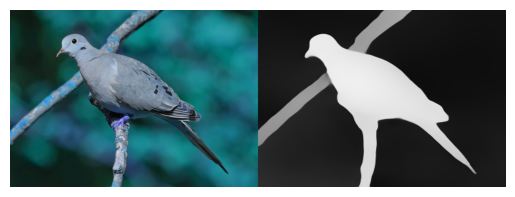

In [6]:
image   = cv2.cvtColor(np.array(image),  cv2.COLOR_BGR2RGB)
depth   = cv2.cvtColor(depth          , cv2.COLOR_GRAY2RGB)
stacked = np.hstack((image, depth))

os.makedirs('assets/'         , exist_ok = True)
cv2.imwrite('assets/dove.jpg' ,           image)
cv2.imwrite('assets/depth.jpg',           depth)

plt.imshow(stacked)
plt.axis(False)

## Timm 용 DPT

In [7]:
start_time       = time.time()
model_type       = 'DPT_Large'

midas            = torch.hub.load('intel-isl/MiDaS', model_type)
midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
print(f'모델 로딩 시간 : {time.time() - start_time:.2f} s')

Using cache found in /home/jovyan/.cache/torch/hub/intel-isl_MiDaS_master


모델 로딩 시간 : 6.43 s


Using cache found in /home/jovyan/.cache/torch/hub/intel-isl_MiDaS_master


In [8]:
if model_type == 'DPT_Large' or model_type == 'DPT_Hybrid':
    transform = midas_transforms.dpt_transform

else:
    transform = midas_transforms.small_transform

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
midas.to(device)
midas.eval()

input_batch = transform(image).to(device)

/opt/conda/envs/tensor/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


추론 시간 : 1.25 s
후처리 시간 : 0.01 s


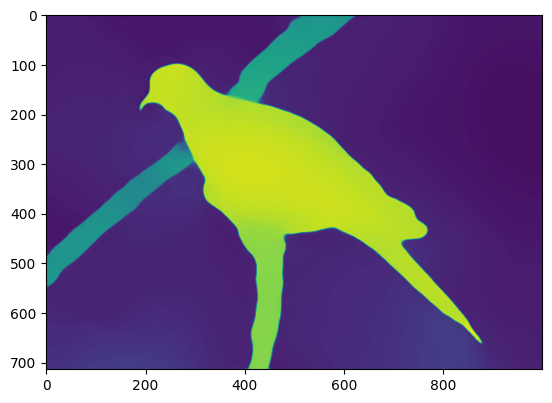

In [9]:
start_time  = time.time()

with torch.no_grad():
    
    prediction = midas(input_batch)
    print(f'추론 시간 : {time.time() - start_time:.2f} s')
    
    start_time  = time.time()
    prediction = torch.nn.functional.interpolate(
                    prediction.unsqueeze(1),
                    size = image.shape[:2],
                    mode = 'bicubic',
                    align_corners = False,
                ).squeeze()

output = prediction.cpu().numpy()
print(f'후처리 시간 : {time.time() - start_time:.2f} s')

plt.imshow(output)

In [10]:
stacked.shape

(714, 2000, 3)

## Depth 이미지로 3D 데이터를 만들어 보자

In [11]:
def process_image(image_path, voxel_size):
    
    voxel_s    = max(voxel_size / 500, 0.0001)
    image_raw  = Image.open(image_path)
    
    image      = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])),
                                 Image.Resampling.LANCZOS)
    
    encoding   = processor(image, return_tensors = 'pt')
    with torch.no_grad():
        outputs = model(**encoding)
        depth   = outputs.predicted_depth
        
    prediction  = torch.nn.functional.interpolate(
                        depth.unsqueeze(1),
                        size = image.size[::-1],
                        mode = 'bicubic',
                        align_corners = False,
                    ).squeeze()
    
    output      = prediction.cpu().numpy()
    depth_image = (output * 255 / np.max(output)).astype('uint8')
    
    try:
        gltf_path, vox_mesh = create_3d_voxels_obj(
                                    np.array(image), depth_image, image_path, voxel_size
                                )
        image     = Image.fromarray(depth_image)
        
        return [image, gltf_path, vox_mesh]
    
    except Exception as e:
        raise Exception('Error reconstructing 3D model')
        
        
def create_3d_voxels_obj(rgb_image, depth_image, image_path, voxel_size):

    depth_o3d  = o3d.geometry.Image(depth_image)
    image_o3d  = o3d.geometry.Image(rgb_image)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
                                        image_o3d, depth_o3d, convert_rgb_to_intensity = False
                                    ) 
    w          = int(depth_image.shape[1])
    h          = int(depth_image.shape[0])

    camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
    camera_intrinsic.set_intrinsics(w, h, 500, 500, w/2, h/2)

    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
                                rgbd_image, camera_intrinsic
                            )

    pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))
    pcd.estimate_normals(
                            search_param = o3d.geometry.KDTreeSearchParamHybrid(radius = 0.01, max_nn = 30)
                        )
    pcd.orient_normals_towards_camera_location(camera_location = np.array([0., 0., 1000.]))
    pcd.transform([[ 1,  0,  0, 0],
                   [ 0, -1,  0, 0],
                   [ 0,  0, -1, 0],
                   [ 0,  0,  0, 1]])
    pcd.transform([[-1,  0,  0, 0],
                   [ 0,  1,  0, 0],
                   [ 0,  0,  1, 0],
                   [ 0,  0,  0, 1]])
    
    
    voxel_size = round(max(pcd.get_max_bound() - pcd.get_min_bound()) * voxel_size, 10)
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size = voxel_size)
    voxels     = voxel_grid.get_voxels()
    
    vox_mesh   = o3d.geometry.TriangleMesh()
    for v in voxels:
        
        cube = o3d.geometry.TriangleMesh.create_box(width = 1, height= 1, depth = 1)
        cube.paint_uniform_color(v.color)
        cube.translate(v.grid_index, relative = False)
        
        vox_mesh += cube
        
    print(voxel_grid, vox_mesh)
    gltf_path = f'assets/test.gltf'
    o3d.io.write_triangle_mesh(gltf_path, vox_mesh, write_triangle_uvs = True)
    
    return gltf_path, vox_mesh
        

In [ ]:
## depth 이미지를 이용해서 3D voxel로 만드는 코드를 따라 해보았지만, 실패하였다..
infos = process_image("assets/dove.jpg", voxel_size = 10)
draw(infos[2])

- 원래 이렇게 만들어져야 하는데
![원래](../../../assets/AI/DPT/DPT2Voxel.jpeg)
- 똥색 복셀 하나만 생겼다..  
![똥색 복셀](../../../assets/AI/DPT/DPT.jpeg)